In [1]:
import numpy as np
import pandas as pd
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# import from scripts
import os
current_wd = os.getcwd()
os.chdir(os.path.abspath("..\\..\\..\\isttc\\scripts"))
#os.chdir(os.path.abspath("C:\\Users\\ipoch\\Documents\\repos\\isttc\\scripts"))
from calculate_tau import fit_single_exp, func_single_exp, func_single_exp_monkey
from cfg_global import project_folder_path
os.chdir(current_wd)

In [2]:
dataset_folder = project_folder_path + 'results\\allen_mice\\dataset\\cut_30min\\'
fig_folder = project_folder_path + 'results\\allen_mice\\fig_draft_paper\\'

#### Load data

In [3]:
units_info_df = pd.read_pickle(dataset_folder + 'sua_list_constrained_units_df.pkl')
units_info_df_subset = units_info_df[['unit_id', 'ecephys_structure_acronym', 'fr_hz_spont_30min']].copy()
units_info_df_subset.head(2)

,unit_id,ecephys_structure_acronym,fr_hz_spont_30min
66,950913540,VISam,6.038333
67,950915005,VISam,4.030556


In [4]:
acf_full_df_file = dataset_folder + 'binned\\acf\\acf_full_50ms_20lags_df.pkl'
acf_full_df = pd.read_pickle(acf_full_df_file)

acf_isttc_full_df_file = dataset_folder + 'non_binned\\acf\\acf_isttc_full_50ms_20lags_df_25dt.pkl'
acf_isttc_full_df = pd.read_pickle(acf_isttc_full_df_file)

In [63]:
acf_full_df.query('unit_id == "950913540"')

,specimen_id,session_id,unit_id,ecephys_structure_acronym,firing_rate,amplitude_cutoff,isi_violations,presence_ratio,acf_0,acf_1,...,acf_11,acf_12,acf_13,acf_14,acf_15,acf_16,acf_17,acf_18,acf_19,acf_20
0,744912849,766640955,950913540,VISam,5.92483027278476,0.00495112650974547,0.157932742873785,0.99,1.0,0.167262,...,0.02416,0.022974,0.010709,0.015712,0.006084,0.006856,0.010183,0.001855,-0.001762,0.004576


#### Calculate tau per unit

In [17]:
n_lags = 20
acf_cols = ['acf_' + str(i) for i in range(n_lags+1)]
print('acf_cols {}'.format(acf_cols))

acf_cols ['acf_0', 'acf_1', 'acf_2', 'acf_3', 'acf_4', 'acf_5', 'acf_6', 'acf_7', 'acf_8', 'acf_9', 'acf_10', 'acf_11', 'acf_12', 'acf_13', 'acf_14', 'acf_15', 'acf_16', 'acf_17', 'acf_18', 'acf_19', 'acf_20']


In [ ]:
acf_full_2d = acf_full_df[acf_cols].values
print(f'acf_2d shape {acf_full_2d.shape}')
acf_full_unit_ids = acf_full_df['unit_id'].values
print(f'acf_full_unit_ids shape {acf_full_unit_ids.shape}')

acf_full_dict = {}
for unit_id_idx, unit_id in enumerate(acf_full_unit_ids):
    if unit_id_idx % 100 == 0:
        print(f'#####\nProcessing unit {unit_id}, {unit_id_idx+1}/{len(acf_full_unit_ids)}, {datetime.now()}')
    fit_popt, fit_pcov, tau, tau_ci, fit_r_squared, explained_var, log_message = fit_single_exp(acf_full_2d[unit_id_idx,:],
                                                                              start_idx_=1, exp_fun_=func_single_exp_monkey)
    taus = {'tau':tau,
            'tau_lower':tau_ci[0],
            'tau_upper':tau_ci[1],
            'fit_r_squared': fit_r_squared,
            'explained_var': explained_var,
            'popt': fit_popt,
            'pcov': fit_pcov,
            'log_message': log_message}
    acf_full_dict[unit_id] = {'taus': taus,
                              'acf': acf_full_2d[unit_id_idx,:]}

In [ ]:
isttc_full_2d = acf_isttc_full_df[acf_cols].values
print(f'isttc_full_2d shape {isttc_full_2d.shape}')
isttc_full_unit_ids = acf_isttc_full_df['unit_id'].values
print(f'isttc_full_unit_ids shape {isttc_full_unit_ids.shape}')

isttc_full_dict = {}
for unit_id_idx, unit_id in enumerate(isttc_full_unit_ids):
    if unit_id_idx % 1000 == 0:
        print(f'#####\nProcessing unit {unit_id}, {unit_id_idx+1}/{len(isttc_full_unit_ids)}, {datetime.now()}')
    fit_popt, fit_pcov, tau, tau_ci, fit_r_squared, explained_var, log_message = fit_single_exp(isttc_full_2d[unit_id_idx,:],
                                                                              start_idx_=1, exp_fun_=func_single_exp_monkey)
    taus = {'tau':tau,
            'tau_lower':tau_ci[0],
            'tau_upper':tau_ci[1],
            'fit_r_squared': fit_r_squared,
            'explained_var': explained_var,
            'popt': fit_popt,
            'pcov': fit_pcov,
            'log_message': log_message}
    isttc_full_dict[unit_id] = {'taus': taus,
                                'acf': isttc_full_2d[unit_id_idx,:]}

In [ ]:
with open(dataset_folder + 'non_binned\\acf\\acf_isttc_full_50ms_20lags_25dt_dict.pkl', "wb") as f:
    pickle.dump(isttc_full_dict, f)

In [ ]:
with open(dataset_folder + 'binned\\acf\\acf_full_50ms_20lags_dict.pkl', "wb") as f:
    pickle.dump(acf_full_dict, f)

#### Load calculated taus

In [5]:
with open(dataset_folder + 'non_binned\\acf\\acf_isttc_full_50ms_20lags_25dt_dict.pkl', "rb") as f:
    isttc_full_dict = pickle.load(f)

with open(dataset_folder + 'binned\\acf\\acf_full_50ms_20lags_dict.pkl', "rb") as f:
    acf_full_dict = pickle.load(f)

with open(dataset_folder + 'binned\\acf\\pearsonr_trial_avg_50ms_20lags_dict.pkl', "rb") as f:
    pearsonr_trial_avg_dict = pickle.load(f)

with open(dataset_folder + 'non_binned\\acf\\sttc_trial_avg_50ms_20lags_dict.pkl', "rb") as f:
    sttc_trial_avg_dict = pickle.load(f)

with open(dataset_folder + 'non_binned\\acf\\sttc_trial_concat_50ms_20lags_dict_25dt.pkl', "rb") as f:
    sttc_trial_concat_dict = pickle.load(f)

In [6]:
print(f'len isttc_full_dict {len(isttc_full_dict)}')
print(f'len acf_full_dict {len(acf_full_dict)}')
print(f'len pearsonr_trial_avg_dict {len(pearsonr_trial_avg_dict)}')
print(f'len sttc_trial_avg_dict {len(sttc_trial_avg_dict)}')
print(f'len sttc_trial_concat_dict {len(sttc_trial_concat_dict)}')

len isttc_full_dict 5775
len acf_full_dict 5775
len pearsonr_trial_avg_dict 5775
len sttc_trial_avg_dict 5775
len sttc_trial_concat_dict 5775


#### Prep data for plots

In [7]:
def calculate_acf_decline_flag(acf_, start_idx=3, end_idx=5):
    acf_decay = np.all(np.diff(acf_[start_idx:end_idx]) <= 0)
    return acf_decay

In [68]:
data = []
for unit_id, unit_data in acf_full_dict.items():
    taus = unit_data['taus']  
    data.append({
        'unit_id': unit_id,
        'tau': taus['tau'],
        'tau_lower': taus['tau_lower'],
        'tau_upper': taus['tau_upper'],
        'fit_r_squared': taus['fit_r_squared'],
        'decline_150_250': calculate_acf_decline_flag(unit_data['acf'], start_idx=2, end_idx=4)
    })
acf_full_plot_df = pd.DataFrame(data)
acf_full_plot_df['method'] = 'acf_full'
acf_full_plot_df['tau_ms'] = acf_full_plot_df['tau'] * 50
acf_full_plot_df = acf_full_plot_df.merge(units_info_df_subset, on='unit_id', how='left')
acf_full_plot_df.head(10)

,unit_id,tau,tau_lower,tau_upper,fit_r_squared,decline_150_250,method,tau_ms,ecephys_structure_acronym,fr_hz_spont_30min
0,950913540,0.580319,3.365490e-01,8.240880e-01,9.361658e-01,False,acf_full,2.901593e+01,VISam,6.038333
1,950915005,0.034201,3.420111e-02,3.420111e-02,-5.534868e-10,False,acf_full,1.710055e+00,VISam,4.030556
2,950915018,0.037646,3.764569e-02,3.764569e-02,-2.423335e-10,False,acf_full,1.882284e+00,VISam,1.903333
3,950913798,0.022190,2.218997e-02,2.218997e-02,-2.805223e-10,False,acf_full,1.109498e+00,VISam,1.045556
4,950915049,0.025056,2.505569e-02,2.505569e-02,-3.396461e-11,True,acf_full,1.252785e+00,VISam,0.953889
5,950913944,6.892935,6.262411e+00,7.523458e+00,9.968823e-01,True,acf_full,3.446467e+02,VISam,10.051111
6,950913961,68518.000388,-4.888652e+08,4.890023e+08,7.475119e-01,False,acf_full,3.425900e+06,VISam,2.027778
7,950913991,0.040627,-3.435218e+07,3.435218e+07,-3.705791e-11,True,acf_full,2.031341e+00,VISam,7.957222
8,950913984,8.470514,7.013852e+00,9.927176e+00,9.918832e-01,True,acf_full,4.235257e+02,VISam,5.980556
9,950915073,3.018096,1.386233e+00,4.649959e+00,8.158901e-01,True,acf_full,1.509048e+02,VISam,4.256111


In [69]:
data = []
for unit_id, unit_data in isttc_full_dict.items():
    taus = unit_data['taus']      
    data.append({
        'unit_id': unit_id,
        'tau': taus['tau'],
        'tau_lower': taus['tau_lower'],
        'tau_upper': taus['tau_upper'],
        'fit_r_squared': taus['fit_r_squared'],
        'decline_150_250': calculate_acf_decline_flag(unit_data['acf'], start_idx=2, end_idx=4)
    })
acf_isttc_full_plot_df = pd.DataFrame(data)
acf_isttc_full_plot_df['method'] = 'isttc_full'
acf_isttc_full_plot_df['tau_ms'] = acf_isttc_full_plot_df['tau'] * 50
acf_isttc_full_plot_df = acf_isttc_full_plot_df.merge(units_info_df_subset, on='unit_id', how='left')
acf_isttc_full_plot_df.head(10)

,unit_id,tau,tau_lower,tau_upper,fit_r_squared,decline_150_250,method,tau_ms,ecephys_structure_acronym,fr_hz_spont_30min
0,950913540,0.544945,1.575598e-01,9.323295e-01,8.511848e-01,False,isttc_full,27.247232,VISam,6.038333
1,950915005,0.036200,3.620012e-02,3.620012e-02,-6.201164e-10,False,isttc_full,1.810006,VISam,4.030556
2,950915018,0.000007,6.544188e-06,6.544188e-06,-2.664535e-15,False,isttc_full,0.000327,VISam,1.903333
3,950913798,0.039372,-3.645167e+07,3.645167e+07,-1.994749e-10,False,isttc_full,1.968585,VISam,1.045556
4,950915049,0.026230,2.622979e-02,2.622979e-02,-1.100835e-10,False,isttc_full,1.311490,VISam,0.953889
5,950913944,6.655973,5.773722e+00,7.538225e+00,9.931633e-01,True,isttc_full,332.798653,VISam,10.051111
6,950913961,0.035085,3.508538e-02,3.508538e-02,-2.629008e-13,False,isttc_full,1.754269,VISam,2.027778
7,950913991,0.040328,-1.976282e+08,1.976282e+08,-2.267246e-10,True,isttc_full,2.016419,VISam,7.957222
8,950913984,7.107258,5.353292e+00,8.861224e+00,9.786446e-01,True,isttc_full,355.362884,VISam,5.980556
9,950915073,2.362720,1.654370e+00,3.071070e+00,9.313602e-01,True,isttc_full,118.135981,VISam,4.256111


In [64]:
def get_trials_plot_df(trial_dict_, acf_cols_, units_info_df_subset_, method_):
    unit_id_l, trial_acf_l, taus_l, fit_r_squared_l, decline_150_250_l = [], [], [], [], []
    for unit_id, unit_data in trial_dict_.items():
        taus = unit_data['taus']  
        acf = unit_data['acf']  
    
        unit_id_l.append([unit_id] * 100)
        trial_acf_l.append(acf)
        taus_l.append([d['tau'] for d in taus])
        fit_r_squared_l.append([d['fit_r_squared'] for d in taus])
        decline_150_250_l.append([calculate_acf_decline_flag(acf, start_idx=2, end_idx=4) for acf in acf])
        
    trial_plot_df = pd.DataFrame(np.vstack(trial_acf_l), columns=acf_cols_)
    trial_plot_df.insert(0, 'unit_id', np.hstack(unit_id_l))
    trial_plot_df.insert(1, 'tau', np.hstack(taus_l))
    trial_plot_df.insert(2, 'fit_r_squared', np.hstack(fit_r_squared_l))
    trial_plot_df.insert(3, 'decline_150_250', np.hstack(decline_150_250_l))
    trial_plot_df.insert(4, 'method', method_)
    
    # print(f'N rows : {len(trial_plot_df)}')
    # rows_with_nans_df = trial_plot_df[trial_plot_df.isna().any(axis=1)]
    # n_rows_with_nan = len(rows_with_nans_df)
    # # units with all 100 iterations containing NaNs
    # n_units_with_all_nans = len(rows_with_nans_df.groupby(by='unit_id', as_index=False)['unit_id'].count().query('unit_id == 100'))
    # trial_plot_df.dropna(inplace=True)
    # print(f'N n_rows_with_nan {n_rows_with_nan}, n_units_with_all_nans {n_units_with_all_nans} removing... new N: {len(trial_plot_df)}')
    
    trial_plot_df.insert(2, 'tau_ms', trial_plot_df['tau'] * 50)

    trial_plot_df = trial_plot_df.merge(units_info_df_subset_, on='unit_id', how='left')

    return trial_plot_df

In [65]:
acf_pearsontr_trial_avg_plot_df = get_trials_plot_df(pearsonr_trial_avg_dict, acf_cols[:-1], units_info_df_subset, 'pearsonr_trial_avg')

In [66]:
acf_sttc_trial_avg_plot_df = get_trials_plot_df(sttc_trial_avg_dict, acf_cols[:-1], units_info_df_subset, 'sttc_trial_avg')

In [67]:
acf_sttc_trial_concat_plot_df = get_trials_plot_df(sttc_trial_concat_dict, acf_cols[:-1], units_info_df_subset, 'sttc_trial_concat')

In [70]:
summary_df = pd.concat([acf_full_plot_df, 
                        acf_isttc_full_plot_df, 
                        acf_pearsontr_trial_avg_plot_df, 
                        acf_sttc_trial_avg_plot_df, 
                        acf_sttc_trial_concat_plot_df])
summary_df.reset_index(inplace=True, drop=True)
summary_df['tau_ms_log10'] = np.log10(summary_df['tau_ms'])
summary_df.head(3)

,unit_id,tau,tau_lower,tau_upper,fit_r_squared,decline_150_250,method,tau_ms,ecephys_structure_acronym,fr_hz_spont_30min,...,acf_11,acf_12,acf_13,acf_14,acf_15,acf_16,acf_17,acf_18,acf_19,tau_ms_log10
0,950913540,0.580319,0.336549,0.824088,9.361658e-01,False,acf_full,29.015926,VISam,6.038333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.462636
1,950915005,0.034201,0.034201,0.034201,-5.534868e-10,False,acf_full,1.710055,VISam,4.030556,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.233010
2,950915018,0.037646,0.037646,0.037646,-2.423335e-10,False,acf_full,1.882284,VISam,1.903333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.274685


In [71]:
total_counts_df = summary_df.groupby('method', as_index=False)['decline_150_250'].count()
total_counts_df.rename(columns={'decline_150_250': 'total_count'}, inplace=True)

units_count_df = summary_df.groupby('method', as_index=False)['decline_150_250'].sum()
units_count_df.rename(columns={'decline_150_250': 'true_count_150_250'}, inplace=True)

units_acf_decline_df = pd.merge(units_count_df, total_counts_df, on='method')
units_acf_decline_df['percentage'] = (units_acf_decline_df['true_count_150_250'] / units_acf_decline_df['total_count']) * 100

units_acf_decline_df

,method,true_count_150_250,total_count,percentage
0,acf_full,4341,5775,75.168831
1,isttc_full,4316,5775,74.735931
2,pearsonr_trial_avg,338412,577500,58.599481
3,sttc_trial_avg,345575,577500,59.839827
4,sttc_trial_concat,346903,577500,60.069784


In [72]:
total_counts_per_area_df = summary_df.groupby(by=['method','ecephys_structure_acronym'], as_index=False)['decline_150_250'].count()
total_counts_per_area_df.rename(columns={'decline_150_250': 'total_count'}, inplace=True)

units_count_per_area_df = summary_df.groupby(by=['method','ecephys_structure_acronym'], as_index=False)['decline_150_250'].sum()
units_count_per_area_df.rename(columns={'decline_150_250': 'true_count'}, inplace=True)

units_acf_decline_per_area_df = pd.merge(total_counts_per_area_df, units_count_per_area_df, on=['method','ecephys_structure_acronym'])
units_acf_decline_per_area_df['percentage'] = (units_acf_decline_per_area_df['true_count'] / units_acf_decline_per_area_df['total_count']) * 100

#units_acf_decline_per_area_df

#### Plots

##### Taus

In [41]:
color_acf_full = '#4783B4'
color_isttc_full = '#E2552A'
color_pearson_trail_avg = 'slategray' 
color_sttc_trail_avg =  '#E97451' 
color_sttc_trail_concat = '#B94E48' 

colors=[color_acf_full, color_isttc_full, color_pearson_trail_avg, color_sttc_trail_avg, color_sttc_trail_concat]

brain_areas_axes_ticks = ['LGd', 'VISp', 'VISl', 'VISrl', 'LP', 'VISal', 'VISpm', 'VISam']
brain_areas_names = ['LGN', 'V1', 'LM', 'RL', 'LP', 'AL', 'PM', 'AM']

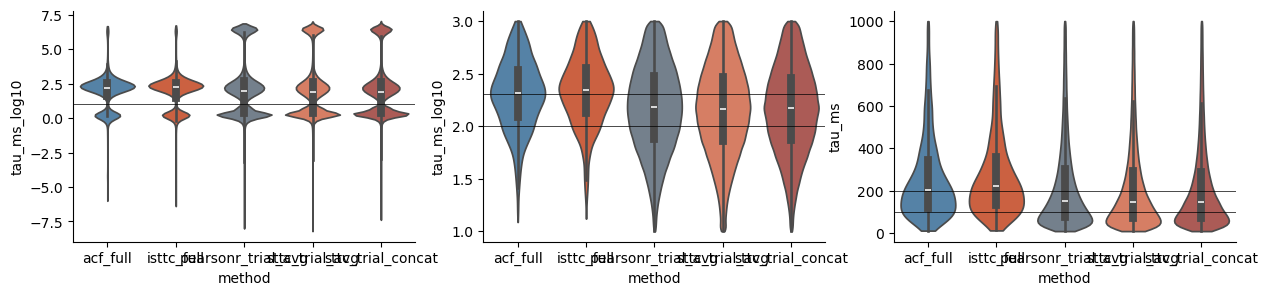

In [42]:
fig, axes = plt.subplots(1,3, figsize=(15, 3))

sns.violinplot(ax=axes[0], x='method', y='tau_ms_log10', hue='method', data=summary_df, cut=0,  density_norm='width', palette=colors, legend=False)
sns.violinplot(ax=axes[1], x='method', y='tau_ms_log10', hue='method', data=summary_df.query('tau_ms <= 1000 and tau_ms > 10'), 
               cut=0,  density_norm='width', palette=colors, legend=False)
sns.violinplot(ax=axes[2], x='method', y='tau_ms', hue='method', 
               data=summary_df.query('tau_ms <= 1000 and tau_ms > 10'), cut=0,  density_norm='width', palette=colors)

axes[0].axhline(y=np.log10(10), lw=0.5, color='k')
axes[1].axhline(y=np.log10(100), lw=0.5, color='k')
axes[1].axhline(y=np.log10(200), lw=0.5, color='k')
axes[2].axhline(y=100, lw=0.5, color='k')
axes[2].axhline(y=200, lw=0.5, color='k')

sns.despine()

In [43]:
summary_df.query('tau_ms <= 1000 and tau_ms > 10').groupby(['method'])['tau_ms'].median()

method
acf_full              204.809377
isttc_full            222.092148
pearsonr_trial_avg    151.536184
sttc_trial_avg        146.735458
sttc_trial_concat     147.257989
Name: tau_ms, dtype: float64

In [ ]:
fig, axes = plt.subplots(2,4, figsize=(16, 7))
plt.subplots_adjust(hspace=0.6, wspace=0.4)

for area_idx, area in enumerate(brain_areas_axes_ticks):
    y_idx = area_idx % 4 
    x_idx = area_idx // 4
    sns.violinplot(ax=axes[x_idx,y_idx], x='method', y='tau_ms', hue='method',
                   data=summary_df.query('tau_ms <= 1000 and tau_ms > 10 and ecephys_structure_acronym == @area'), 
                   cut=0,  density_norm='width', palette=colors)
    axes[x_idx,y_idx].set_title(area)

for ax in axes.flat:
    ax.set_xticks(['acf_full', 'isttc_full', 'pearsonr_trial_avg','sttc_trial_avg', 'sttc_trial_concat'])
    ax.set_xticklabels(['ACF full', 'iSTTC full', 'Pearson trial avg', 'STTC trial avg', 'STTC trial concat'], 
                       rotation=45, ha='right', fontsize=8)

sns.despine()

In [ ]:
df_median = summary_df.query('tau_ms <= 1000 and tau_ms > 10').groupby(['ecephys_structure_acronym', 'method'])['tau_ms'].median().unstack()
annot_vals = df_median.round(0).astype(int)

sns.heatmap(df_median, annot=annot_vals, fmt="d", cmap="viridis")
#sns.heatmap(df_median, annot=True, cmap='viridis')

In [ ]:
df_median = summary_df.groupby(['ecephys_structure_acronym', 'method'])['tau_ms'].median().unstack()
annot_vals = df_median.round(0).astype(int)

sns.heatmap(df_median, annot=annot_vals, fmt="d", cmap="viridis")

In [ ]:
summary_df.groupby(['ecephys_structure_acronym', 'method'])['tau_ms'].median()

In [ ]:
annot_vals = mad_df.round(0).astype(int)
sns.heatmap(mad_df, annot=annot_vals, fmt="d", cmap="viridis")

In [ ]:
df = summary_df.query('tau_ms <= 1000 and tau_ms > 10')
# Step 1: Calculate median
median_df = df.groupby(['ecephys_structure_acronym', 'method'])['tau_ms'].median().unstack()

# Step 2: Calculate MAD
def mad(x):
    return np.median(np.abs(x - np.median(x)))

mad_df = df.groupby(['ecephys_structure_acronym', 'method'])['tau_ms'].apply(mad).unstack()

# Step 3: Heatmap of medians
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(median_df, cmap='viridis', annot=median_df.round(0).astype(int), fmt='d', ax=ax, cbar=True)

# Step 4: Normalize MAD to [0,1] for dot sizing
norm_mad = (mad_df - mad_df.min().min()) / (mad_df.max().max() - mad_df.min().min())

# Overlay MAD as dot size
for i, region in enumerate(median_df.index):
    for j, method in enumerate(median_df.columns):
        spread = norm_mad.loc[region, method]
        radius = 0.3 * spread
        ax.add_patch(plt.Circle((j + 0.5, i + 0.5), radius, color='white', alpha=0.4))

plt.title('Median tau_ms (color) + MAD (dot size)')
plt.xlabel('method')
plt.ylabel('region')
plt.tight_layout()
plt.show()

In [ ]:
# Step 1: Aggregate median and MAD
def mad(x):
    return np.median(np.abs(x - np.median(x)))

agg_df = df.groupby(['ecephys_structure_acronym', 'method'])['tau_ms'].agg(
    median='median',
    mad=mad
).reset_index()

# Step 2: Plot using matplotlib directly for error bars
plt.figure(figsize=(10, 6))

regions = agg_df['ecephys_structure_acronym'].unique()
colors = sns.color_palette("tab10", len(regions))

for i, region in enumerate(regions):
    region_data = agg_df[agg_df['ecephys_structure_acronym'] == region]
    
    # Sort methods for consistent plotting
    methods = region_data['method']
    x = np.arange(len(methods)) + i * 0.1  # offset to dodge points
    y = region_data['median']
    yerr = region_data['mad']
    
    plt.errorbar(
        x, y, yerr=yerr,
        fmt='o', capsize=4, label=region,
        color=colors[i], alpha=0.8
    )

# Tidy up x-axis
plt.xticks(np.arange(len(methods)), methods.unique(), rotation=45)
plt.ylabel("tau_ms (median ± MAD)")
plt.xlabel("Method")
plt.title("Median tau_ms per Method with MAD Error Bars")
plt.legend(title="Region")
plt.tight_layout()
plt.show()

In [ ]:
sns.boxplot(data=summary_df.query('tau_ms <= 1000 and tau_ms > 10'), x="method", y="tau_ms", hue="ecephys_structure_acronym", dodge=True)

In [ ]:
fig, axes = plt.subplots(2,4, figsize=(16, 6))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

for area_idx, area in enumerate(brain_areas_axes_ticks):
    y_idx = area_idx % 4 
    x_idx = area_idx // 4
    sns.violinplot(ax=axes[x_idx,y_idx], x='method', y='tau_ms_log10', hue='method',
                   data=summary_df.query('ecephys_structure_acronym == @area'), 
                   cut=0,  density_norm='width', palette=colors)
    axes[x_idx,y_idx].axhline(y=np.log10(10), lw=0.5, color='k')
    axes[x_idx,y_idx].set_title(area)

sns.despine()

##### Quality metrics

C:\Users\ipochino\AppData\Local\Temp\ipykernel_15940\15142943.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=units_acf_decline_df, x='method', y='percentage', palette=colors)
C:\Users\ipochino\AppData\Local\Temp\ipykernel_15940\15142943.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(['ACF full', 'iSTTC full', 'Pearson trial avg', 'STTC trial avg', 'STTC trial concat'], rotation=45, ha='right')


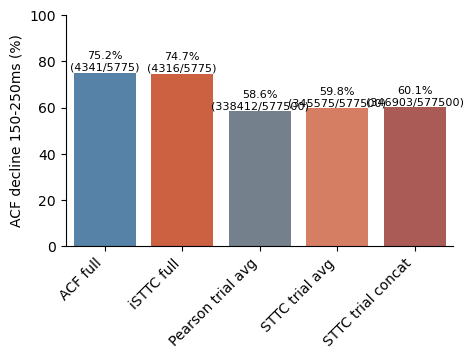

In [73]:
fig, axes = plt.subplots(1, 1, figsize=(5, 3))

sns.barplot(data=units_acf_decline_df, x='method', y='percentage', palette=colors)

axes.set_ylabel('ACF decline 150-250ms (%)')
axes.set_xlabel('')
axes.set_ylim(0, 100)  

axes.set_xticklabels(['ACF full', 'iSTTC full', 'Pearson trial avg', 'STTC trial avg', 'STTC trial concat'], rotation=45, ha='right')
axes.set_xticks(['acf_full', 'isttc_full', 'pearsonr_trial_avg', 'sttc_trial_avg', 'sttc_trial_concat'])

for p, (true_count, total_count) in zip(axes.patches, zip(units_acf_decline_df['true_count_150_250'], units_acf_decline_df['total_count'])):
    percentage = p.get_height()
    axes.annotate(f'{percentage:.1f}%\n({true_count}/{total_count})', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=8, color='black')

sns.despine()

# if save_fig:
#     fig.savefig(fig_folder + 'criteria2_all_units.png', bbox_inches='tight', dpi=300)
#     fig.savefig(fig_folder + 'criteria2_all_units.svg', bbox_inches='tight')

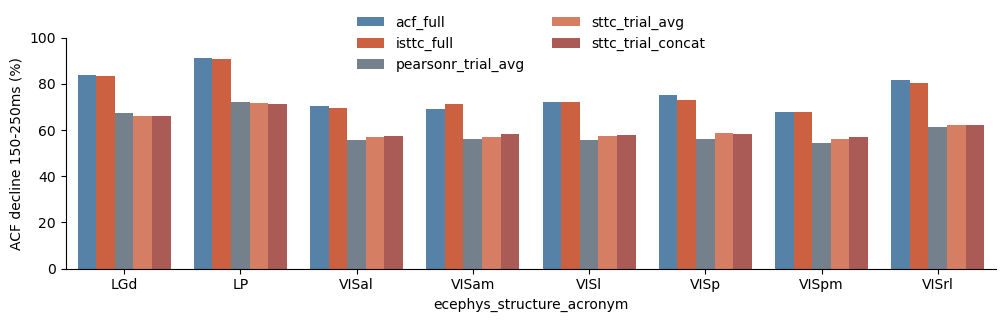

In [74]:
fig, axes = plt.subplots(1, 1, figsize=(12, 3))

sns.barplot(data=units_acf_decline_per_area_df, x='ecephys_structure_acronym', y='percentage', hue='method', palette=colors)

axes.set_ylabel('ACF decline 150-250ms (%)')
# axes.set_xlabel('')
axes.set_ylim(0, 100)  
axes.legend(frameon=False, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)

# axes.set_xticklabels(['ACF full', 'iSTTC full', 'Pearson trial avg', 'STTC trial avg', 'STTC trial concat'], rotation=45, ha='right')
# axes.set_xticks(['acf_full', 'isttc_full', 'pearsonr_trial_avg', 'sttc_trial_avg', 'sttc_trial_concat'])

# for p, (true_count, total_count) in zip(axes.patches, zip(units_acf_decline_df['true_count'], units_acf_decline_df['total_count'])):
#     percentage = p.get_height()
#     axes.annotate(f'{percentage:.1f}%\n({true_count}/{total_count})', 
#                 (p.get_x() + p.get_width() / 2., p.get_height()), 
#                 ha='center', va='bottom', fontsize=8, color='black')

sns.despine()

# if save_fig:
#     fig.savefig(fig_folder + 'criteria2_all_units.png', bbox_inches='tight', dpi=300)
#     fig.savefig(fig_folder + 'criteria2_all_units.svg', bbox_inches='tight')

C:\Users\ipochino\AppData\Local\Temp\ipykernel_15940\2533611563.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(ax=axes, x='method', y='fit_r_squared', data=summary_df.query('decline_150_250 == True'),
C:\Users\ipochino\AppData\Local\Temp\ipykernel_15940\2533611563.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(['ACF full', 'iSTTC full', 'Pearson trial avg', 'STTC trial avg', 'STTC trial concat'], rotation=45, ha='right')


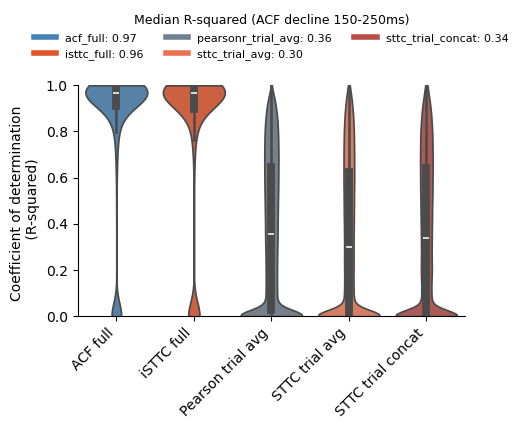

In [75]:
fig, axes = plt.subplots(1, 1, figsize=(5, 3))

sns.violinplot(ax=axes, x='method', y='fit_r_squared', data=summary_df.query('decline_150_250 == True'), 
               cut=0, density_norm='width', palette=colors)
axes.set_ylabel('Coefficient of determination \n (R-squared)')
axes.set_xlabel('')
axes.set_ylim(0, 1)  
axes.set_xticklabels(['ACF full', 'iSTTC full', 'Pearson trial avg', 'STTC trial avg', 'STTC trial concat'], rotation=45, ha='right')
axes.set_xticks(['acf_full', 'isttc_full', 'pearsonr_trial_avg', 'sttc_trial_avg', 'sttc_trial_concat'])

# Compute mean R-squared for each method
mean_r2 = summary_df.query('decline_150_250 == True').groupby('method')['fit_r_squared'].median()

# Create legend labels
legend_labels = [f"{method}: {mean_r2:.2f}" for method, mean_r2 in mean_r2.items()]

# Add legend on top
handles = [plt.Line2D([0], [0], color=color, lw=4) for color in colors]
legend = axes.legend(handles, legend_labels, title="Median R-squared (ACF decline 150-250ms)", loc='upper center',
                     bbox_to_anchor=(0.5, 1.35), fontsize=8, title_fontsize=9, ncol=3, frameon=False)

sns.despine()

# if save_fig:
#     fig.savefig(fig_folder + 'rsquared_acf_decline_units.png', bbox_inches='tight', dpi=300)
#     fig.savefig(fig_folder + 'rsquared_acf_decline_units.svg', bbox_inches='tight')

In [61]:
summary_df

,unit_id,tau,tau_lower,tau_upper,fit_r_squared,decline_150_250,method,tau_ms,ecephys_structure_acronym,fr_hz_spont_30min,...,acf_11,acf_12,acf_13,acf_14,acf_15,acf_16,acf_17,acf_18,acf_19,tau_ms_log10
0,950913540,0.580319,0.336549,0.824088,9.361658e-01,True,acf_full,29.015926,VISam,6.038333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.462636
1,950915005,0.034201,0.034201,0.034201,-5.534868e-10,True,acf_full,1.710055,VISam,4.030556,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.233010
2,950915018,0.037646,0.037646,0.037646,-2.423335e-10,False,acf_full,1.882284,VISam,1.903333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.274685
3,950913798,0.022190,0.022190,0.022190,-2.805223e-10,False,acf_full,1.109498,VISam,1.045556,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.045127
4,950915049,0.025056,0.025056,0.025056,-3.396461e-11,False,acf_full,1.252785,VISam,0.953889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.097876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1744045,951190594,1.267121,NaN,NaN,2.352834e-01,True,sttc_trial_concat,63.356048,VISrl,1.460000,...,0.378248,0.374209,0.311561,0.109864,0.163339,0.078765,0.142152,0.176270,0.000000,1.801788
1744046,951190594,9040.340951,NaN,NaN,5.903136e-01,False,sttc_trial_concat,452017.047540,VISrl,1.460000,...,0.152334,-0.012789,-0.004292,-0.049501,0.131002,-0.035354,-0.036158,-0.023125,0.000000,5.655155
1744047,951190594,2.177605,NaN,NaN,2.829225e-01,False,sttc_trial_concat,108.880237,VISrl,1.460000,...,-0.074085,-0.069894,-0.009278,0.027447,-0.000054,-0.059981,-0.057917,-0.034675,0.377895,2.036949
1744048,951190594,0.098822,NaN,NaN,2.633320e-01,False,sttc_trial_concat,4.941114,VISrl,1.460000,...,0.039739,0.128767,-0.049713,0.101274,0.043614,0.218895,0.178261,-0.028992,-0.038217,0.693825


In [52]:
summary_df.query('method == "sttc_trail_concat"')['fit_r_squared'].values 

array([], dtype=float64)

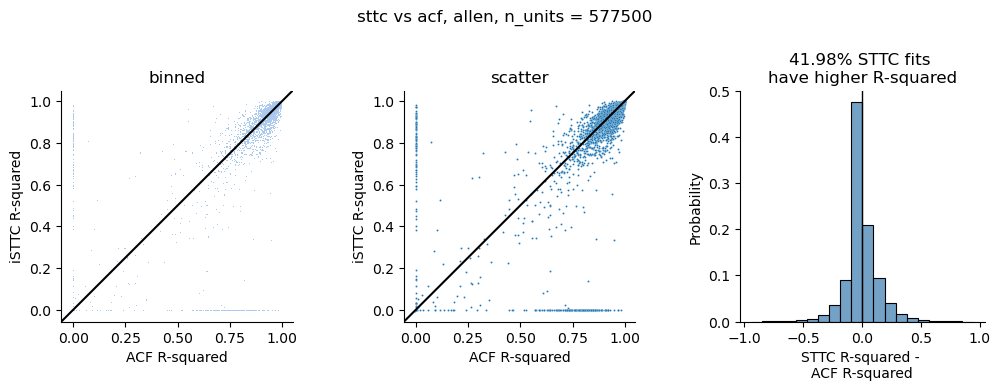

In [76]:
fig, axes = plt.subplots(1,3, figsize=(12,3))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

sns.histplot(ax=axes[0], x=summary_df.query('method == "acf_full"')['fit_r_squared'].values, 
             y=summary_df.query('method == "isttc_full"')['fit_r_squared'].values, bins=200)
axes[0].plot([0, 1], [0, 1], c='k', transform=axes[0].transAxes)
axes[0].set_aspect('equal', adjustable='box')
axes[0].set_xlabel('ACF R-squared')
axes[0].set_ylabel('iSTTC R-squared')
axes[0].set_title('binned')

sns.scatterplot(ax=axes[1], x=summary_df.query('method == "acf_full"')['fit_r_squared'].values, 
             y=summary_df.query('method == "isttc_full"')['fit_r_squared'].values, s=2)
axes[1].plot([0, 1], [0, 1], c='k', transform=axes[1].transAxes)
axes[1].set_aspect('equal', adjustable='box')
axes[1].set_xlabel('ACF R-squared')
axes[1].set_ylabel('iSTTC R-squared')
axes[1].set_title('scatter')

r_squared_diff = summary_df.query('method == "sttc_trial_concat"')['fit_r_squared'].values - summary_df.query('method == "pearsonr_trial_avg"')['fit_r_squared'].values
n_sttc_better = sum(r_squared_diff > 0)
n_sttc_better_perc = n_sttc_better / len(r_squared_diff) * 100

sns.histplot(ax=axes[2], x=r_squared_diff, stat='probability', bins=20, kde=False, color='steelblue')
axes[2].axvline(x=0, lw=1, c='k')
axes[2].set_xlabel('STTC R-squared - \nACF R-squared')
axes[2].set_title('{}% STTC fits \nhave higher R-squared'.format(np.round(n_sttc_better_perc,2)))

fig.suptitle('sttc vs acf, allen, n_units = ' + str(len(r_squared_diff)), y=1.15)

sns.despine()

#fig.savefig(isttc_results_folder_path + 'allen_sttc_vs_pearson.png' , bbox_inches='tight')

#### FR vs taus

In [ ]:
summary_df['fr_hz_spont_30min_log10'] = np.log10(summary_df['fr_hz_spont_30min'])

In [ ]:
sns.regplot(x='fr_hz_spont_30min_log10', y='tau_ms_log10', 
            data=summary_df.query('tau_ms > 10 and tau_ms < 1000 and method == "acf_full"'), scatter=False, color=color_acf_full)

sns.regplot(x='fr_hz_spont_30min_log10', y='tau_ms_log10', 
            data=summary_df.query('tau_ms > 10 and tau_ms < 1000 and method == "isttc_full"'), scatter=False, color=color_isttc_full)

sns.regplot(x='fr_hz_spont_30min_log10', y='tau_ms_log10', 
            data=summary_df.query('tau_ms > 10 and tau_ms < 1000 and method == "pearsonr_trial_avg"'), scatter=False, color=color_pearson_trail_avg)

sns.regplot(x='fr_hz_spont_30min_log10', y='tau_ms_log10', 
            data=summary_df.query('tau_ms > 10 and tau_ms < 1000 and method == "sttc_trial_avg"'), scatter=False, color=color_sttc_trail_avg)